# ICS 438 Project: Fake News
## by: Leilani Reich

### Link to Dataset: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=True.csv

### GitHub Repo: https://github.com/leilani-reich/ICS438-FinalProject-FakeNews

## Install Libraries

In [122]:
#!pip install pyspark
#!python -m pip install -U gensim
#%pip install -U sentence-transformers
!pip install --user annoy

In [1]:
# Create new Spark Context
from pyspark import SparkContext
sc = SparkContext()

In [2]:
# Create new Spark Session
from pyspark.sql import SparkSession
session = SparkSession(sc)

### Load in Data

In [16]:
# Some of the data like the text contains double quotes, which really cause a lot of issues!
# So I need escape='"'
fake_df = session.read.csv("Fake.csv", inferSchema = True, header=True, multiLine=True, escape='"')

print(type(fake_df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [17]:
fake_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



In [22]:
true_df = session.read.csv("True.csv", inferSchema = True, header=True, multiLine=True, escape='"')

print(type(true_df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [23]:
true_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



## Preprocess Data

In [24]:
# Remove missing info

fake_df = fake_df.dropna()
true_df = true_df.dropna()


fake news types ['US_News', 'left-news', 'politics', 'Government News', 'Middle-east', 'News']
fake news types counts: [783, 4459, 6841, 1570, 778, 9050]
+---------------+-----+
|        subject|count|
+---------------+-----+
|        US_News|  783|
|      left-news| 4459|
|       politics| 6841|
|Government News| 1570|
|    Middle-east|  778|
|           News| 9050|
+---------------+-----+



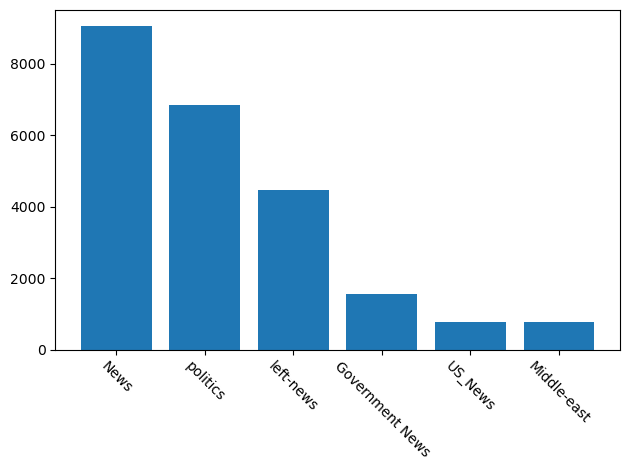

In [55]:
import matplotlib.pyplot as plt

# Visualize the types of fake news by frequency

# Get the unique subject names for the articles
fake_news_types = fake_df.select("subject").distinct()
fake_news_types = list(fake_news_types.toPandas()["subject"])
print("fake news types", fake_news_types)

# Get the total counts for each type of article
fake_news_types_counts = fake_df.groupBy("subject").count().select("count")
fake_news_types_counts = list(fake_news_types_counts.toPandas()["count"])
print("fake news types counts:", fake_news_types_counts)

# Show subject names and corresponding counts in table
fake_df.groupBy("subject").count().show()

# Create dictionary with subjects as keys and counts as values
fake_news_dict = dict(zip(fake_news_types, fake_news_types_counts))

# Sort in ascending order by value
fake_news_by_frequency = sorted(fake_news_dict.items(), key=lambda x: x[1], reverse=True)

# Get sorted keys and values
fn_subjects, fn_counts = zip(*fake_news_by_frequency)

# Show subject names and corresponding counts in barchart
plt.bar(x = fn_subjects, height = fn_counts)

plt.xticks(rotation=-45)

plt.tight_layout()

plt.show()

true news types ['worldnews', 'politicsNews']
true news types counts: [10145, 11272]
+------------+-----+
|     subject|count|
+------------+-----+
|   worldnews|10145|
|politicsNews|11272|
+------------+-----+



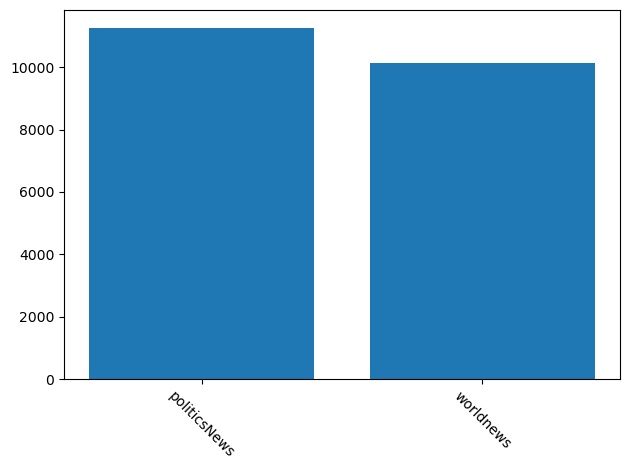

In [59]:
# Visualize the types of true news by frequency

# Get the unique subject names for the articles
true_news_types = true_df.select("subject").distinct()
true_news_types = list(true_news_types.toPandas()["subject"])
print("true news types", true_news_types)

# Get the total counts for each type of article
true_news_types_counts = true_df.groupBy("subject").count().select("count")
true_news_types_counts = list(true_news_types_counts.toPandas()["count"])
print("true news types counts:", true_news_types_counts)

# Show subject names and corresponding counts in table
true_df.groupBy("subject").count().show()

# Create dictionary with subjects as keys and counts as values
true_news_dict = dict(zip(true_news_types, true_news_types_counts))

# Sort in ascending order by value
true_news_by_frequency = sorted(true_news_dict.items(), key=lambda x: x[1], reverse=True)

# Get sorted keys and values
fn_subjects, fn_counts = zip(*true_news_by_frequency)

# Show subject names and corresponding counts in barchart
plt.bar(x = fn_subjects, height = fn_counts)

plt.xticks(rotation=-45)

plt.tight_layout()


+-----------------+-----+
|             date|count|
+-----------------+-----+
|     May 30, 2017|   27|
|    March 2, 2017|   24|
|   April 29, 2016|   20|
|   March 25, 2016|   28|
|      Oct 4, 2017|   13|
|      Oct 8, 2016|   20|
|     Sep 27, 2015|   12|
|      Jun 4, 2015|    9|
|February 25, 2016|   25|
|      Nov 1, 2017|   17|
|      Oct 9, 2017|    7|
|     Sep 14, 2016|   15|
|      Aug 9, 2015|    8|
|     Feb 10, 2016|   14|
|December 22, 2017|    1|
|    July 18, 2017|    4|
|    June 27, 2017|   10|
|     May 25, 2017|   26|
|    March 7, 2017|   22|
| December 7, 2016|   21|
+-----------------+-----+
only showing top 20 rows

Top 10 most prevalent dates of fake news posts [('May 30, 2017', 27), ('March 2, 2017', 24), ('April 29, 2016', 20), ('March 25, 2016', 28), ('Oct 4, 2017', 13), ('Oct 8, 2016', 20), ('Sep 27, 2015', 12), ('Jun 4, 2015', 9), ('February 25, 2016', 25), ('Nov 1, 2017', 17)]


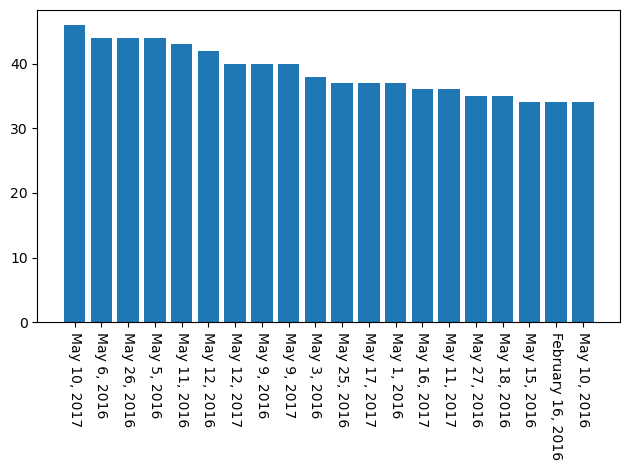

In [72]:
# Visualizing the top 20 most prominent dates of fake news

# Get the unique dates for the articles
fake_news_dates = fake_df.select("date").distinct()
fake_news_dates = list(fake_news_dates.toPandas()["date"])
#print("fake news dates", fake_news_dates)

# Get the total counts for each type of article
fake_news_dates_counts = fake_df.groupBy("date").count().select("count")
fake_news_dates_counts = list(fake_news_dates_counts.toPandas()["count"])
#print("fake news dates counts:", fake_news_dates_counts)

# Show dates and corresponding counts in table
fake_df.groupBy("date").count().show()

# Create dictionary with subjects as keys and counts as values
fake_news_dict = dict(zip(fake_news_dates, fake_news_dates_counts))

# Sort in ascending order by value
fake_news_dates_by_frequency = sorted(fake_news_dict.items(), key=lambda x: x[1], reverse=True)

print("Top 10 most prevalent dates of fake news posts", list(fake_news_dict.items())[:10])

# Get sorted keys and values
fn_dates, fn_counts = zip(*fake_news_dates_by_frequency)

# Show subject names and corresponding counts in barchart
plt.bar(x = fn_dates[:20], height = fn_counts[:20])

plt.xticks(rotation=-90)

plt.tight_layout()

plt.show()

+------------------+-----+
|              date|count|
+------------------+-----+
|     May 18, 2017 |   34|
|   March 15, 2017 |   30|
|  August 29, 2016 |   18|
|  August 24, 2016 |   11|
|     July 7, 2016 |   13|
|      May 2, 2016 |    9|
| October 29, 2017 |   47|
|    June 24, 2017 |    1|
|   April 12, 2017 |   31|
|  August 10, 2016 |    8|
|      May 3, 2016 |    9|
|    April 4, 2016 |   14|
|    July 27, 2017 |   36|
|    June 26, 2017 |   22|
|      May 4, 2017 |   22|
|   April 30, 2017 |    6|
|September 2, 2017 |   36|
| December 4, 2016 |   12|
|November 20, 2016 |   16|
| October 18, 2016 |   18|
+------------------+-----+
only showing top 20 rows

Top 10 most prevalent dates of true news posts [('May 18, 2017 ', 34), ('March 15, 2017 ', 30), ('August 29, 2016 ', 18), ('August 24, 2016 ', 11), ('July 7, 2016 ', 13), ('May 2, 2016 ', 9), ('October 29, 2017 ', 47), ('June 24, 2017 ', 1), ('April 12, 2017 ', 31), ('August 10, 2016 ', 8)]


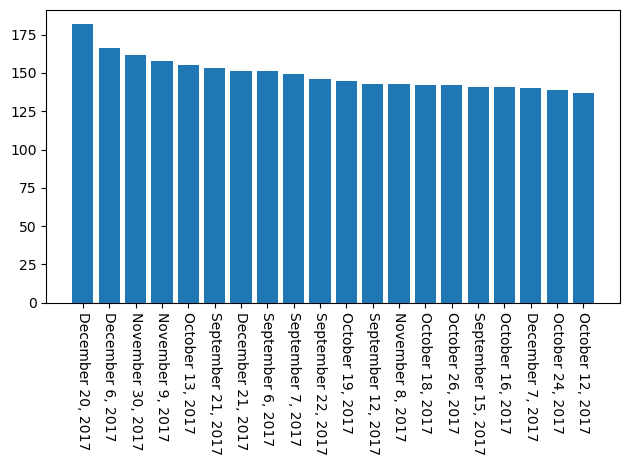

In [73]:
# Visualizing the top 20 most prominent dates of true news

# Get the unique dates for the articles
true_news_dates = true_df.select("date").distinct()
true_news_dates = list(true_news_dates.toPandas()["date"])
#print("true news dates", true_news_dates)

# Get the total counts for each type of article
true_news_dates_counts = true_df.groupBy("date").count().select("count")
true_news_dates_counts = list(true_news_dates_counts.toPandas()["count"])
#print("true news dates counts:", true_news_dates_counts)

# Show dates and corresponding counts in table
true_df.groupBy("date").count().show()

# Create dictionary with subjects as keys and counts as values
true_news_dict = dict(zip(true_news_dates, true_news_dates_counts))

# Sort in ascending order by value
true_news_dates_by_frequency = sorted(true_news_dict.items(), key=lambda x: x[1], reverse=True)

print("Top 10 most prevalent dates of true news posts", list(true_news_dict.items())[:10])

# Get sorted keys and values
fn_dates, fn_counts = zip(*true_news_dates_by_frequency)

# Show subject names and corresponding counts in barchart
plt.bar(x = fn_dates[:20], height = fn_counts[:20])

plt.xticks(rotation=-90)

plt.tight_layout()

plt.show()

In [98]:
# Preprocess the text data
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_short

# Do some common cleaning options to remove noise from text
def clean_text(text):
    text_p1 = remove_stopwords(text)
    text_p2 = strip_punctuation(text_p1)
    text_p3 = strip_short(text_p2)
    return text_p3.lower()
    
    # How to remove @ from text?


In [96]:
# I combined the title and text and am considering them together
fake_text = fake_df.rdd.map(lambda x: clean_text(x["title"]+ " " + x["text"]))

print(type(fake_text))

print(fake_text.first())

<class 'pyspark.rdd.PipelinedRDD'>
donald trump sends out embarrassing new year’s eve message this disturbing donald trump couldn wish americans happy new year leave that instead shout enemies haters dishonest fake news media the reality star job couldn country rapidly grows stronger smarter want wish friends supporters enemies haters dishonest fake news media happy healthy new year president angry pants tweeted 2018 great year america country rapidly grows stronger smarter want wish friends supporters enemies haters dishonest fake news media happy healthy new year 2018 great year america donald trump realdonaldtrump december 2017trump tweet went welll expect what kind president sends new year greeting like despicable petty infantile gibberish only trump his lack decency won allow rise gutter long wish american citizens happy new year bishop talbert swan talbertswan december 2017no likes calvin calvinstowell december 2017your impeachment 2018 great year america accept regaining control

In [97]:
# I combined the title and text and am considering them together
true_text = true_df.rdd.map(lambda x: clean_text(x["title"]+ " " + x["text"]))

print(type(true_text))

print(true_text.first())

<class 'pyspark.rdd.PipelinedRDD'>
budget fight looms republicans flip fiscal script washington reuters the head conservative republican faction congress voted month huge expansion national debt pay tax cuts called “fiscal conservative” sunday urged budget restraint 2018 keeping sharp pivot way republicans representative mark meadows speaking cbs’ “face nation drew hard line federal spending lawmakers bracing battle january when return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want big budget increase military spending democrats want proportional increases non defense “discretionary” spending programs support education scientific research infrastructure public health environmental protection “the trump administration willing say ‘we’re going increase non defense discretionary spending percent meadows ch

## Encode Data

In [100]:
# Create SentenceTransformer model

from sentence_transformers import SentenceTransformer

# https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('paraphrase-MiniLM-L3-v2')


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [110]:
# Create embeddings - BATCH THIS?

# Create embed files
fake_embed = open("Fake.embed", "w+")
true_embed = open("True.embed", "w+")

print("Embedding Dimension:", model.encode(fake_text.first()).reshape(1, -1).shape)


Embedding Dimension: (1, 384)


In [112]:
import numpy as np

# Embed the fake text
fake_text.foreach(lambda x: np.savetxt(fake_embed, model.encode(x).reshape(1, -1)))

In [113]:
# Embed the true text
true_text.foreach(lambda x: np.savetxt(true_embed, model.encode(x).reshape(1, -1)))

In [115]:
# Close files after finish writing to them
fake_embed.close()
true_embed.close()

## Can we classify news as being fake or true?

In [120]:
# Split files into train and test

fake_embed = session.read.format("text").load("Fake.embed")

true_embed = session.read.format("text").load("True.embed")

print(type(fake_embed))
print(type(true_embed))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [123]:
# Using Approximate Nearest Neighbors Oh Yeah! (ANNOY)
from annoy import AnnoyIndex

# https://github.com/spotify/annoy

f = 384 # Embedding dimension

t = AnnoyIndex(f, 'angular')

fake_embed.foreach(lambda vector: t.add_item(i, vector))
    
t.build(10) # 10 trees
t.save('test.ann')

u = AnnoyIndex(f, 'angular')
u.load('test.ann') # super fast, will just mmap the file
print(u.get_nns_by_item(0, 10)) # will find the 10 nearest neighbors

ModuleNotFoundError: No module named 'annoy'

In [ ]:

# Which type of news has the most negative sentiment (Sentiment Analysis)?
# What/who are the topics of fake vs. true news (Name Entity Recognition)?
# Can we classify news as being fake or true?